# CS4186 Assignment 1: CNN model

Importing All Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
import cv2
import os
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
# from sklearn.metrics.pairwise import cosine_similarity

from utils import query_crop, similarity

C:\Users\Rahil\anaconda3\envs\cv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
# def similarity(query_feat, gallery_feat):
#     sim = cosine_similarity(query_feat, gallery_feat)
#     sim = np.squeeze(sim)
#     return sim

def resnet_extraction(img, featsave_path):
    resnet_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
    img_transform = resnet_transform(img).to(device) #normalize the input image and transform it to tensor.
    
    img_transform = torch.unsqueeze(img_transform, 0) #Set batchsize as 1. You can enlarge the batchsize to accelerate.
    
    feats = cnn_model(img_transform) # extract feature
    feats_np = feats.cpu().detach().numpy() # convert tensor to numpy
    np.save(featsave_path, feats_np, allow_pickle=True) # save the featur

def feat_extractor_gallery(gallery_dir, feat_savedir):
    for img_file in tqdm(os.listdir(gallery_dir)):
        img = cv2.imread(os.path.join(gallery_dir, img_file))
        img = img[:,:,::-1] #bgr2rgb
        img_resize = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC) # resize the image
        featsave_path = os.path.join(feat_savedir, img_file.split('.')[0]+'.npy')
        resnet_extraction(img_resize, featsave_path)

# Extract the query feature
def feat_extractor_query():
    query_dir = './datasets_4186/query_4186/'
    txt_dir = './datasets_4186/query_txt_4186/'
    save_dir =  './datasets_4186/query_cropped/'
    featsave_dir = './datasets_4186/query_feature/'
    for query_file in tqdm(os.listdir(query_dir)):
        if query_file.endswith(".DS_Store"):
            continue
        print(query_file)
        img_name = query_file[0:query_file.find('.')]
        txt_file = img_name+'.txt'
        featsave_file = img_name+'_feats.npy'
        query_path = os.path.join(query_dir, query_file)
        txt_path = os.path.join(txt_dir, txt_file)
        save_path = os.path.join(save_dir, query_file)
        featsave_path =os.path.join(featsave_dir, featsave_file) 
        crop = query_crop(query_path, txt_path, save_path)
        crop_resize = cv2.resize(crop, (224, 224), interpolation=cv2.INTER_CUBIC)
        resnet_extraction(crop_resize, featsave_path)

def retrival_idx(query_path, gallery_dir):
    query_feat = np.load(query_path, allow_pickle=True)
    # print(query_feat)
    
    dict_values = {}
    # print(dict_values)
    
    for gallery_file in os.listdir(gallery_dir):
        gallery_feat = np.load(os.path.join(gallery_dir, gallery_file),  allow_pickle=True)
        gallery_idx = gallery_file.split('.')[0] + '.jpg'
        sim = similarity(query_feat, gallery_feat)
        # print(sim)
        dict_values[gallery_idx] = sim
    sorted_dict = sorted(dict_values.items(), key=lambda item: item[1]) # Sort the similarity score
    best_ten = sorted_dict[-10:] # Get the best five retrived images
    # print(best_ten)
    return best_ten

# def retrival_idx(query_path, gallery_dir):
#     query_feat = np.load(query_path, allow_pickle=True)
#     print(query_feat)
    
#     dict_values = {}
#     print(dict_values)
    
#     for gallery_file in os.listdir(gallery_dir):
#         gallery_feat = np.load(os.path.join(gallery_dir, gallery_file),  allow_pickle=True)
#         gallery_idx = gallery_file.split('.')[0] + '.jpg'
#         sim = cosine_similarity(query_feat, gallery_feat)
#         print(sim)
#         dict_values[gallery_idx] = sim
#     sorted_dict = sorted(dict_values.items(), key=lambda item: item[1]) # Sort the similarity score
#     best_ten = sorted_dict[-10:] # Get the best five retrived images
#     print(best_ten)
#     return best_ten

def visulization(retrived, query):
    plt.subplot(2, 3, 1)
    plt.title('query')
    query_img = cv2.imread(query)
    img_rgb_rgb = query_img[:,:,::-1]
    plt.imshow(img_rgb_rgb)
    for i in range(5):
        img_path = './data/gallery/' + retrived[i][0]
        img = cv2.imread(img_path)
        img_rgb = img[:,:,::-1]
        plt.subplot(2, 3, i+2)
        plt.title(retrived[i][1])
        plt.imshow(img_rgb)
    plt.show()

## Defining the Model

In [3]:
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'

# cnn_model = models.vgg16(pretrained=True)
# modules=list(cnn_model.children())[:-1]
# cnn_model=nn.Sequential(*modules)
# for p in cnn_model.parameters():
#     p.requires_grad = False

# cnn_model = cnn_model.to(device)

cnn_model = models.vgg16(pretrained=True).to(device)
cnn_model_features = cnn_model.features
cnn_model_features.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Main Function

Responsible for Extracting Features

In [5]:
feat_extractor_query()

gallery_dir = './datasets_4186/gallery_4186/'
feat_savedir = './datasets_4186/gallery_feature/'

feat_extractor_gallery(gallery_dir, feat_savedir)


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

1258.jpg


 29%|███████████████████████▋                                                           | 6/21 [00:02<00:04,  3.09it/s]

1656.jpg
1709.jpg
2032.jpg
2040.jpg
2176.jpg
2461.jpg
27.jpg
2714.jpg


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:02<00:00,  9.76it/s]

316.jpg
35.jpg
3502.jpg
3557.jpg
3833.jpg
3906.jpg
4354.jpg
4445.jpg


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.48it/s]


4716.jpg
4929.jpg
776.jpg


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:02<00:00, 40.78it/s]


In [4]:
queryf_dir = './datasets_4186/query_feature/'
gallery_dir = './datasets_4186/gallery_feature/'
query_dir = './datasets_4186/query_4186/'

for queryf_file in os.listdir(queryf_dir):
    print(os.path.join(queryf_dir, queryf_file))

./datasets_4186/query_feature/1258_feats.npy
./datasets_4186/query_feature/1656_feats.npy
./datasets_4186/query_feature/1709_feats.npy
./datasets_4186/query_feature/2032_feats.npy
./datasets_4186/query_feature/2040_feats.npy
./datasets_4186/query_feature/2176_feats.npy
./datasets_4186/query_feature/2461_feats.npy
./datasets_4186/query_feature/2714_feats.npy
./datasets_4186/query_feature/27_feats.npy
./datasets_4186/query_feature/316_feats.npy
./datasets_4186/query_feature/3502_feats.npy
./datasets_4186/query_feature/3557_feats.npy
./datasets_4186/query_feature/35_feats.npy
./datasets_4186/query_feature/3833_feats.npy
./datasets_4186/query_feature/3906_feats.npy
./datasets_4186/query_feature/4354_feats.npy
./datasets_4186/query_feature/4445_feats.npy
./datasets_4186/query_feature/4716_feats.npy
./datasets_4186/query_feature/4929_feats.npy
./datasets_4186/query_feature/776_feats.npy


2962.jpg 0.68862295
4700.jpg 0.6902053
848.jpg 0.69110155
3141.jpg 0.6996869
4154.jpg 0.70124394
3689.jpg 0.70166326
2941.jpg 0.7066506
4937.jpg 0.70798695
2368.jpg 0.7145618
2403.jpg 0.77600527


TypeError: 'NoneType' object is not subscriptable

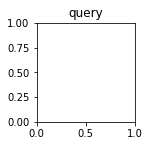

In [5]:
queryf_dir = './datasets_4186/query_feature/'
gallery_dir = './datasets_4186/gallery_feature/'
query_dir = './datasets_4186/query_4186/'

for queryf_file in os.listdir(queryf_dir):
    # print("Reached here 1 {}".format(queryf_file))
    # print(queryf_file + "\n Best ten:")
    # print(os.path.join(queryf_dir, queryf_file))
    # print("Reached here 2")
    best_ten = retrival_idx(os.path.join(queryf_dir, queryf_file), gallery_dir) # retrieve top 10 matching images in the gallery.
    # print("Reached here 3")
    
    for i in best_ten:
        print(i[0], i[1])
    best_ten.reverse()
    visulization(best_ten, queryf_file.split('_')[0]+'.jpg') # Visualize the retrieval results